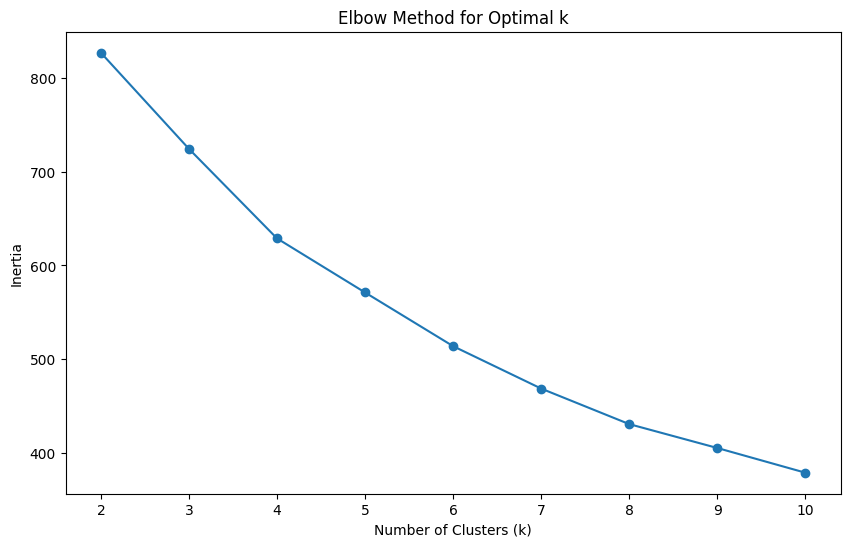

Davies-Bouldin Index for k=4: 1.4939989571140886


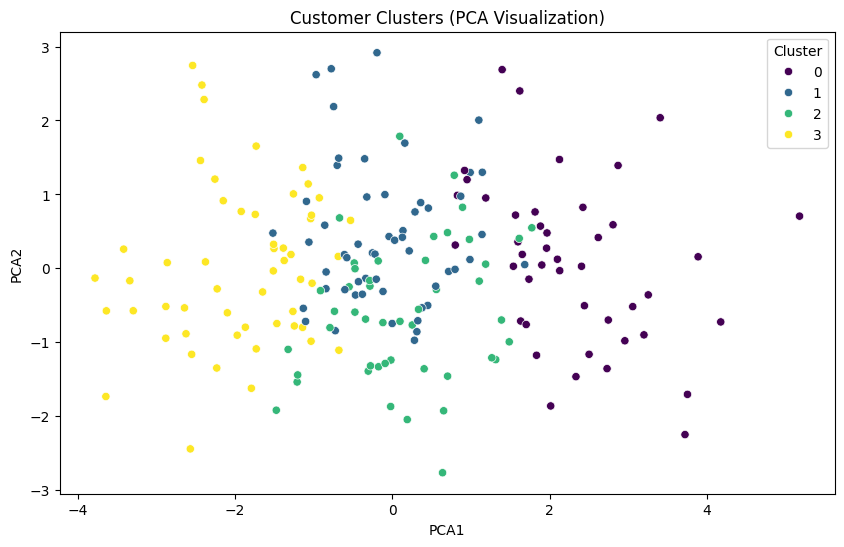

Clustering Results:
Number of Clusters: 4
Davies-Bouldin Index: 1.4939989571140886
Cluster Sizes:
Cluster
1    55
3    53
2    47
0    44
Name: count, dtype: int64


In [26]:
#Task 3
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


customers = pd.read_csv('/content/drive/MyDrive/Space/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Space/Transactions.csv')


customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],
    'Quantity': 'sum',
    'TransactionID': 'count'
}).reset_index()
customer_transactions.columns = ['CustomerID', 'TotalSpending', 'AvgTransactionValue', 'TotalQuantity', 'TransactionFrequency']


customer_profiles = pd.merge(customers, customer_transactions, on='CustomerID')


customer_profiles['SignupDate'] = pd.to_datetime(customer_profiles['SignupDate'])
customer_profiles['DaysSinceSignup'] = (pd.Timestamp.now() - customer_profiles['SignupDate']).dt.days

customer_profiles['Region'] = customer_profiles['Region'].astype('category').cat.codes


features = customer_profiles[['Region', 'DaysSinceSignup', 'TotalSpending', 'AvgTransactionValue', 'TotalQuantity', 'TransactionFrequency']]


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#Determining the optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

#Ploting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

#Choosing k=4 (based on the elbow plot)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(features_scaled)

#Calculating DB Index
db_index = davies_bouldin_score(features_scaled, customer_profiles['Cluster'])
print(f"Davies-Bouldin Index for k={k}: {db_index}")

#Visualizing clusters using PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
customer_profiles['PCA1'] = features_pca[:, 0]
customer_profiles['PCA2'] = features_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_profiles, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title("Customer Clusters (PCA Visualization)")
plt.show()

#Clustering Report
print("Clustering Results:")
print(f"Number of Clusters: {k}")
print(f"Davies-Bouldin Index: {db_index}")
print("Cluster Sizes:")
print(customer_profiles['Cluster'].value_counts())